In [13]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-damp/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn, arrange_data
from nn_models import MLP, PSD
from hnn import HNN, HNN_structure
from utils import L2_loss, from_pickle

# #%%
# pend_baseline_stats = from_pickle(EXPERIMENT_DIR + 'pend-baseline-stats.pkl')
# baseline_nfe = np.array(pend_baseline_stats['nfe'])
# baseline_diff_nfe = baseline_nfe[1:] - baseline_nfe[:-1]
# baseline_forward_time = np.array(pend_baseline_stats['forward_time'])
# baseline_backward_time = np.array(pend_baseline_stats['backward_time'])


# #%%
# pend_hnn_stats = from_pickle(EXPERIMENT_DIR + 'pend-hnn_ode-stats.pkl')
# hnn_nfe = np.array(pend_hnn_stats['nfe'])
# hnn_diff_nfe = hnn_nfe[1:] - hnn_nfe[:-1]
# hnn_forward_time = np.array(pend_hnn_stats['forward_time'])
# hnn_backward_time = np.array(pend_hnn_stats['backward_time'])


 ## Set some notebook constants

In [14]:
DPI = 300
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 4,
         'gpu': 0}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d


 ## Inspect the dataset

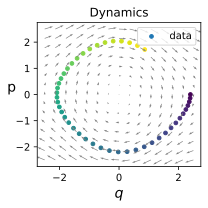

In [15]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
R = 2.5
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
# data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(radius=2.4, y0=np.array([2,0]), noise_std=0)
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')


In [16]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, damping, num_points):
    if structure == False:
        # Neural net without structure
        output_dim = args.input_dim if baseline else 1
        nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity).to(device)
        damp_model = PSD(input_dim=args.input_dim, hidden_dim=30, 
                    diag_dim=args.input_dim, nonlinearity=args.nonlinearity).to(device)
        model = HNN(args.input_dim, differentiale_model=nn_model, device=device, 
                baseline=baseline, damp=damping, dampNet=damp_model).to(device)
    elif structure and baseline == False:
        pass
    else:
        raise RuntimeError('argument *baseline* and *structure* cannot both be true')
    
    model_name = 'baseline_ode' if baseline else 'hnn_ode'
    struct = '-struct' if structure else ''
    damp = '-damp' if damping else ''
    path = '{}pend-{}{}{}-p{}.tar'.format(args.save_dir, model_name, struct, damp, num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    return model


 ## Get vector fields

In [17]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32).to(device)
    mesh_dx = model.time_derivative(_, mesh_x)
    return mesh_dx.detach().cpu().numpy()


 ## Integrate along vector fields

In [18]:
from torchdiffeq import odeint 
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2).to(device)
        dx = model.time_derivative(_, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)


 ## Run analysis

In [19]:
base_ode_model = get_model(args, baseline=True, structure=False, damping=False, num_points=args.num_points)
hnn_ode_model = get_model(args, baseline=False, structure=False, damping=False, num_points=args.num_points)
hnn_ode_damp_model = get_model(args, baseline=False, structure=False, damping=True, num_points=args.num_points)

# get their vector fields
R = 2.6
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
# data = get_dataset(radius=2.0)
base_field = get_vector_field(base_ode_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_ode_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
hnn_damp_field = get_vector_field(hnn_ode_damp_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,28]
# y0 = torch.tensor([[2.1, 0]], requires_grad=True).to(device)
y0 = np.asarray([2.1, 0])
# t_eval = torch.linspace(t_span[0], t_span[1], 1000).to(device)
# rtol = torch.tensor(1e-12, dtype=torch.float64)
# rtol = 1e-12
# base_ivp = odeint(base_ode_model.time_derivative, y0, t_eval, rtol=rtol) # (1000, 1, 2)
# hnn_ivp = odeint(hnn_ode_model.time_derivative, y0, t_eval, rtol=rtol)

kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_ode_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_ode_model, t_span, y0, **kwargs)
hnn_damp_ivp = integrate_model(hnn_ode_damp_model, t_span, y0, **kwargs)


In [20]:
# plot training data
data = get_dataset(args.seed)
train_x0 = data['x'][0,:,:] # (25, 2)


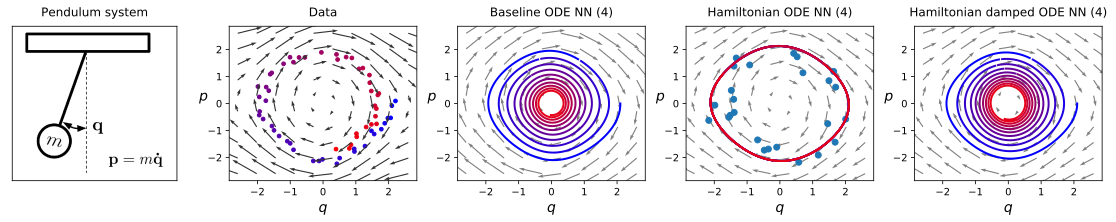

In [21]:
###### PLOT ######



fig = plt.figure(figsize=(16, 3.2), facecolor='white', dpi=DPI)
# plot physical system
fig.add_subplot(1, 5, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/pendulum.png')
plt.imshow(schema)
plt.title("Pendulum system", pad=10)

# plot dynamics
fig.add_subplot(1, 5, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=[0,4], radius=2.1, y0=y0)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=14, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 5, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline ODE NN ({})".format(args.num_points), pad=10)

# plot HNN
fig.add_subplot(1, 5, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian ODE NN ({})".format(args.num_points), pad=10)

plt.scatter(train_x0[:, 0], train_x0[:, 1])

# plot HNN damping
fig.add_subplot(1, 5, 5, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_damp_field[:,0], hnn_damp_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_damp_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian damped ODE NN ({})".format(args.num_points), pad=10)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend-damp-p{}.{}'.format(args.fig_dir, args.num_points, FORMAT))


 ## Quantitative analysis
 * Choose trajectories from the test set
 * Measure vector field loss at each point
 * Integrate along trajectory and measure mean loss between points

In [22]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # integrate along baseline vector field
    base_path = integrate_model(base_ode_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_ode_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_damp_path = integrate_model(hnn_ode_damp_model, t_span, x0, **kwargs)
    hnn_damp_x = hnn_damp_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    return true_x, base_x, hnn_x, hnn_damp_x

def vector_field_loss(x, dx_hat):
    dx = circular_vector_field(t=None, x=x)
    return np.mean((dx - dx_hat)**2)

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)


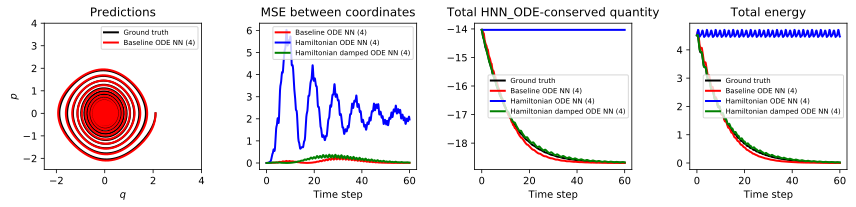

In [23]:
x0 = np.asarray([2.1, 0])

# integration
t_span=[0,60]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x, hnn_damp_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
# plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian ODE NN', linewidth=2)
# plt.plot(hnn_damp_x[:,0], hnn_damp_x[:,1], 'g-', label='Hamiltonian damped ODE NN', linewidth=2)
plt.xlim(-2.5,4) ; plt.ylim(-2.5,4)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, ((true_x-hnn_damp_x)**2).mean(-1), 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN_ODE-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_ode_model(torch.Tensor(true_x).to(device)).detach().cpu().numpy().squeeze()
base_hq = hnn_ode_model(torch.Tensor(base_x).to(device)).detach().cpu().numpy().squeeze()
hnn_hq = hnn_ode_model(torch.Tensor(hnn_x).to(device)).detach().cpu().numpy().squeeze()
hnn_damp_hq = hnn_ode_model(torch.Tensor(hnn_damp_x).to(device)).detach().cpu().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_damp_hq, 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
hnn_damp_e = np.stack([hamiltonian_fn(c) for c in hnn_damp_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_damp_e, 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend-damp-p{}-integration.{}'.format(args.fig_dir, args.num_points, FORMAT))



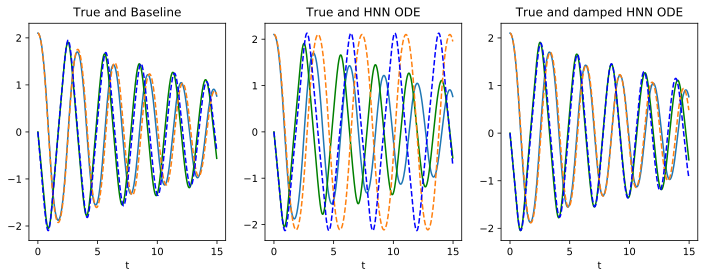

In [24]:

# plotting the difference between trajectories
tpad = 7
pts = 000
pte = 500
fig = plt.figure(figsize=[12, 4], dpi=DPI)
plt.subplot(1,3,1)
plt.title("True and Baseline", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], base_x[pts:pte,0], '--', t_eval[pts:pte], base_x[pts:pte,1], 'b--')

plt.subplot(1,3,2)
plt.title("True and HNN ODE", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], hnn_x[pts:pte,0], '--', t_eval[pts:pte], hnn_x[pts:pte,1], 'b--')

plt.subplot(1,3,3)
plt.title("True and damped HNN ODE", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], hnn_damp_x[pts:pte,0], '--', t_eval[pts:pte], hnn_damp_x[pts:pte,1], 'b--')


In [25]:
### no noise, no bias, radius

In [26]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-damp/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn, arrange_data
from nn_models import MLP, PSD
from hnn import HNN, HNN_structure
from utils import L2_loss, from_pickle

# #%%
# pend_baseline_stats = from_pickle(EXPERIMENT_DIR + 'pend-baseline-stats.pkl')
# baseline_nfe = np.array(pend_baseline_stats['nfe'])
# baseline_diff_nfe = baseline_nfe[1:] - baseline_nfe[:-1]
# baseline_forward_time = np.array(pend_baseline_stats['forward_time'])
# baseline_backward_time = np.array(pend_baseline_stats['backward_time'])


# #%%
# pend_hnn_stats = from_pickle(EXPERIMENT_DIR + 'pend-hnn_ode-stats.pkl')
# hnn_nfe = np.array(pend_hnn_stats['nfe'])
# hnn_diff_nfe = hnn_nfe[1:] - hnn_nfe[:-1]
# hnn_forward_time = np.array(pend_hnn_stats['forward_time'])
# hnn_backward_time = np.array(pend_hnn_stats['backward_time'])


 ## Set some notebook constants

In [27]:
DPI = 300
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 4,
         'gpu': 0}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d


 ## Inspect the dataset

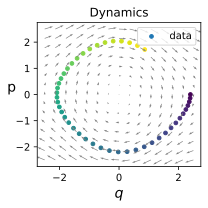

In [28]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
R = 2.5
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
# data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(radius=2.4, y0=np.array([2,0]), noise_std=0)
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')


In [29]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, damping, num_points):
    if structure == False:
        # Neural net without structure
        output_dim = args.input_dim if baseline else 1
        nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity).to(device)
        damp_model = PSD(input_dim=args.input_dim, hidden_dim=30, 
                    diag_dim=args.input_dim, nonlinearity=args.nonlinearity).to(device)
        model = HNN(args.input_dim, differentiale_model=nn_model, device=device, 
                baseline=baseline, damp=damping, dampNet=damp_model).to(device)
    elif structure and baseline == False:
        pass
    else:
        raise RuntimeError('argument *baseline* and *structure* cannot both be true')
    
    model_name = 'baseline_ode' if baseline else 'hnn_ode'
    struct = '-struct' if structure else ''
    damp = '-damp' if damping else ''
    path = '{}pend-{}{}{}-p{}.tar'.format(args.save_dir, model_name, struct, damp, num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    return model


 ## Get vector fields

In [30]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32).to(device)
    mesh_dx = model.time_derivative(_, mesh_x)
    return mesh_dx.detach().cpu().numpy()


 ## Integrate along vector fields

In [31]:
from torchdiffeq import odeint 
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2).to(device)
        dx = model.time_derivative(_, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)


 ## Run analysis

In [32]:
base_ode_model = get_model(args, baseline=True, structure=False, damping=False, num_points=args.num_points)
hnn_ode_model = get_model(args, baseline=False, structure=False, damping=False, num_points=args.num_points)
hnn_ode_damp_model = get_model(args, baseline=False, structure=False, damping=True, num_points=args.num_points)

# get their vector fields
R = 2.6
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
# data = get_dataset(radius=2.0)
base_field = get_vector_field(base_ode_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_ode_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
hnn_damp_field = get_vector_field(hnn_ode_damp_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,28]
# y0 = torch.tensor([[2.1, 0]], requires_grad=True).to(device)
y0 = np.asarray([2.1, 0])
# t_eval = torch.linspace(t_span[0], t_span[1], 1000).to(device)
# rtol = torch.tensor(1e-12, dtype=torch.float64)
# rtol = 1e-12
# base_ivp = odeint(base_ode_model.time_derivative, y0, t_eval, rtol=rtol) # (1000, 1, 2)
# hnn_ivp = odeint(hnn_ode_model.time_derivative, y0, t_eval, rtol=rtol)

kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_ode_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_ode_model, t_span, y0, **kwargs)
hnn_damp_ivp = integrate_model(hnn_ode_damp_model, t_span, y0, **kwargs)


In [33]:
# plot training data
data = get_dataset(args.seed)
train_x0 = data['x'][0,:,:] # (25, 2)


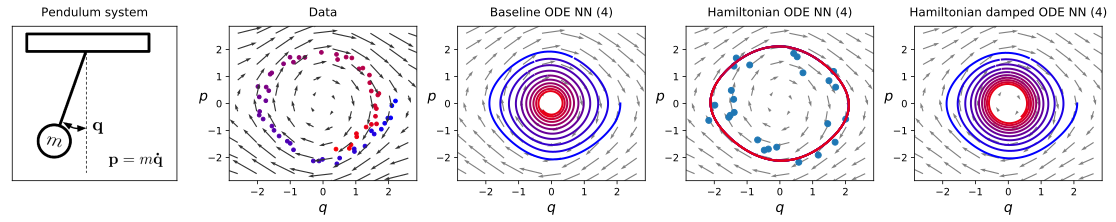

In [34]:
###### PLOT ######



fig = plt.figure(figsize=(16, 3.2), facecolor='white', dpi=DPI)
# plot physical system
fig.add_subplot(1, 5, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/pendulum.png')
plt.imshow(schema)
plt.title("Pendulum system", pad=10)

# plot dynamics
fig.add_subplot(1, 5, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=[0,4], radius=2.1, y0=y0)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=14, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 5, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline ODE NN ({})".format(args.num_points), pad=10)

# plot HNN
fig.add_subplot(1, 5, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian ODE NN ({})".format(args.num_points), pad=10)

plt.scatter(train_x0[:, 0], train_x0[:, 1])

# plot HNN damping
fig.add_subplot(1, 5, 5, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_damp_field[:,0], hnn_damp_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_damp_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian damped ODE NN ({})".format(args.num_points), pad=10)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend-damp-p{}.{}'.format(args.fig_dir, args.num_points, FORMAT))


 ## Quantitative analysis
 * Choose trajectories from the test set
 * Measure vector field loss at each point
 * Integrate along trajectory and measure mean loss between points

In [35]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # integrate along baseline vector field
    base_path = integrate_model(base_ode_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_ode_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_damp_path = integrate_model(hnn_ode_damp_model, t_span, x0, **kwargs)
    hnn_damp_x = hnn_damp_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    return true_x, base_x, hnn_x, hnn_damp_x

def vector_field_loss(x, dx_hat):
    dx = circular_vector_field(t=None, x=x)
    return np.mean((dx - dx_hat)**2)

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)


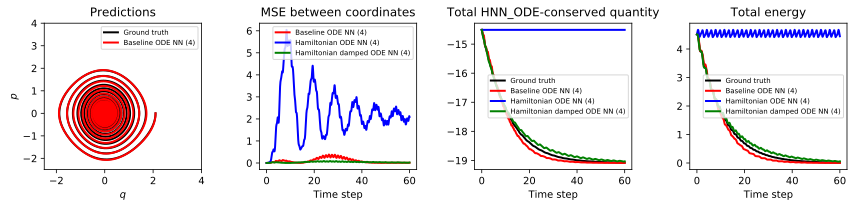

In [36]:
x0 = np.asarray([2.1, 0])

# integration
t_span=[0,60]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x, hnn_damp_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
# plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian ODE NN', linewidth=2)
# plt.plot(hnn_damp_x[:,0], hnn_damp_x[:,1], 'g-', label='Hamiltonian damped ODE NN', linewidth=2)
plt.xlim(-2.5,4) ; plt.ylim(-2.5,4)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, ((true_x-hnn_damp_x)**2).mean(-1), 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN_ODE-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_ode_model(torch.Tensor(true_x).to(device)).detach().cpu().numpy().squeeze()
base_hq = hnn_ode_model(torch.Tensor(base_x).to(device)).detach().cpu().numpy().squeeze()
hnn_hq = hnn_ode_model(torch.Tensor(hnn_x).to(device)).detach().cpu().numpy().squeeze()
hnn_damp_hq = hnn_ode_model(torch.Tensor(hnn_damp_x).to(device)).detach().cpu().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_damp_hq, 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
hnn_damp_e = np.stack([hamiltonian_fn(c) for c in hnn_damp_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_damp_e, 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend-damp-p{}-integration.{}'.format(args.fig_dir, args.num_points, FORMAT))



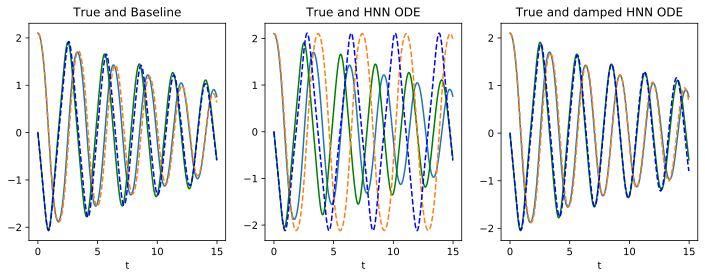

In [37]:

# plotting the difference between trajectories
tpad = 7
pts = 000
pte = 500
fig = plt.figure(figsize=[12, 4], dpi=DPI)
plt.subplot(1,3,1)
plt.title("True and Baseline", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], base_x[pts:pte,0], '--', t_eval[pts:pte], base_x[pts:pte,1], 'b--')

plt.subplot(1,3,2)
plt.title("True and HNN ODE", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], hnn_x[pts:pte,0], '--', t_eval[pts:pte], hnn_x[pts:pte,1], 'b--')

plt.subplot(1,3,3)
plt.title("True and damped HNN ODE", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], hnn_damp_x[pts:pte,0], '--', t_eval[pts:pte], hnn_damp_x[pts:pte,1], 'b--')


In [38]:
### no noise, no bias, uniform

In [39]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-damp/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn, arrange_data
from nn_models import MLP, PSD
from hnn import HNN, HNN_structure
from utils import L2_loss, from_pickle

# #%%
# pend_baseline_stats = from_pickle(EXPERIMENT_DIR + 'pend-baseline-stats.pkl')
# baseline_nfe = np.array(pend_baseline_stats['nfe'])
# baseline_diff_nfe = baseline_nfe[1:] - baseline_nfe[:-1]
# baseline_forward_time = np.array(pend_baseline_stats['forward_time'])
# baseline_backward_time = np.array(pend_baseline_stats['backward_time'])


# #%%
# pend_hnn_stats = from_pickle(EXPERIMENT_DIR + 'pend-hnn_ode-stats.pkl')
# hnn_nfe = np.array(pend_hnn_stats['nfe'])
# hnn_diff_nfe = hnn_nfe[1:] - hnn_nfe[:-1]
# hnn_forward_time = np.array(pend_hnn_stats['forward_time'])
# hnn_backward_time = np.array(pend_hnn_stats['backward_time'])


 ## Set some notebook constants

In [40]:
DPI = 300
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 4,
         'gpu': 0}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d


 ## Inspect the dataset

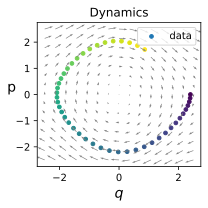

In [41]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
R = 2.5
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
# data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(radius=2.4, y0=np.array([2,0]), noise_std=0)
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')


In [42]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, damping, num_points):
    if structure == False:
        # Neural net without structure
        output_dim = args.input_dim if baseline else 1
        nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity).to(device)
        damp_model = PSD(input_dim=args.input_dim, hidden_dim=30, 
                    diag_dim=args.input_dim, nonlinearity=args.nonlinearity).to(device)
        model = HNN(args.input_dim, differentiale_model=nn_model, device=device, 
                baseline=baseline, damp=damping, dampNet=damp_model).to(device)
    elif structure and baseline == False:
        pass
    else:
        raise RuntimeError('argument *baseline* and *structure* cannot both be true')
    
    model_name = 'baseline_ode' if baseline else 'hnn_ode'
    struct = '-struct' if structure else ''
    damp = '-damp' if damping else ''
    path = '{}pend-{}{}{}-p{}.tar'.format(args.save_dir, model_name, struct, damp, num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    return model


 ## Get vector fields

In [43]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32).to(device)
    mesh_dx = model.time_derivative(_, mesh_x)
    return mesh_dx.detach().cpu().numpy()


 ## Integrate along vector fields

In [44]:
from torchdiffeq import odeint 
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2).to(device)
        dx = model.time_derivative(_, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)


 ## Run analysis

In [45]:
base_ode_model = get_model(args, baseline=True, structure=False, damping=False, num_points=args.num_points)
hnn_ode_model = get_model(args, baseline=False, structure=False, damping=False, num_points=args.num_points)
hnn_ode_damp_model = get_model(args, baseline=False, structure=False, damping=True, num_points=args.num_points)

# get their vector fields
R = 2.6
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
# data = get_dataset(radius=2.0)
base_field = get_vector_field(base_ode_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_ode_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
hnn_damp_field = get_vector_field(hnn_ode_damp_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,28]
# y0 = torch.tensor([[2.1, 0]], requires_grad=True).to(device)
y0 = np.asarray([2.1, 0])
# t_eval = torch.linspace(t_span[0], t_span[1], 1000).to(device)
# rtol = torch.tensor(1e-12, dtype=torch.float64)
# rtol = 1e-12
# base_ivp = odeint(base_ode_model.time_derivative, y0, t_eval, rtol=rtol) # (1000, 1, 2)
# hnn_ivp = odeint(hnn_ode_model.time_derivative, y0, t_eval, rtol=rtol)

kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_ode_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_ode_model, t_span, y0, **kwargs)
hnn_damp_ivp = integrate_model(hnn_ode_damp_model, t_span, y0, **kwargs)


In [46]:
# plot training data
data = get_dataset(args.seed)
train_x0 = data['x'][0,:,:] # (25, 2)


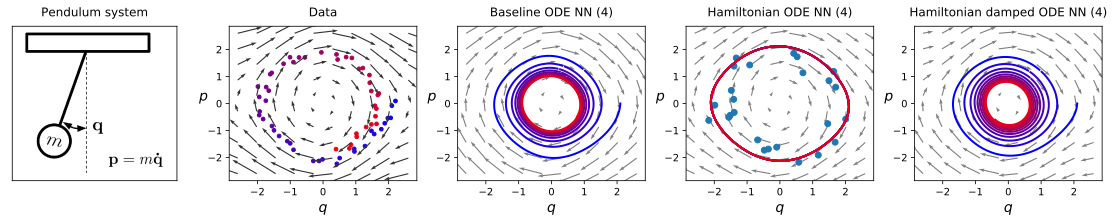

In [47]:
###### PLOT ######



fig = plt.figure(figsize=(16, 3.2), facecolor='white', dpi=DPI)
# plot physical system
fig.add_subplot(1, 5, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/pendulum.png')
plt.imshow(schema)
plt.title("Pendulum system", pad=10)

# plot dynamics
fig.add_subplot(1, 5, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=[0,4], radius=2.1, y0=y0)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=14, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 5, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline ODE NN ({})".format(args.num_points), pad=10)

# plot HNN
fig.add_subplot(1, 5, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian ODE NN ({})".format(args.num_points), pad=10)

plt.scatter(train_x0[:, 0], train_x0[:, 1])

# plot HNN damping
fig.add_subplot(1, 5, 5, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_damp_field[:,0], hnn_damp_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_damp_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian damped ODE NN ({})".format(args.num_points), pad=10)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend-damp-p{}.{}'.format(args.fig_dir, args.num_points, FORMAT))


 ## Quantitative analysis
 * Choose trajectories from the test set
 * Measure vector field loss at each point
 * Integrate along trajectory and measure mean loss between points

In [48]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # integrate along baseline vector field
    base_path = integrate_model(base_ode_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_ode_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_damp_path = integrate_model(hnn_ode_damp_model, t_span, x0, **kwargs)
    hnn_damp_x = hnn_damp_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    return true_x, base_x, hnn_x, hnn_damp_x

def vector_field_loss(x, dx_hat):
    dx = circular_vector_field(t=None, x=x)
    return np.mean((dx - dx_hat)**2)

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)


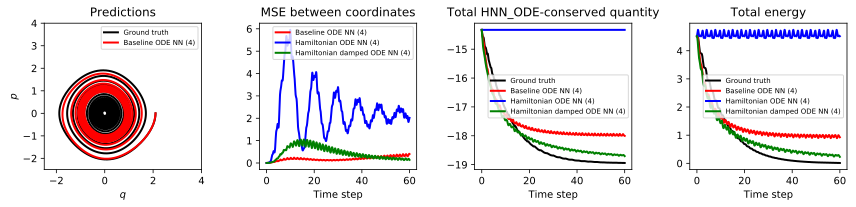

In [49]:
x0 = np.asarray([2.1, 0])

# integration
t_span=[0,60]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x, hnn_damp_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
# plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian ODE NN', linewidth=2)
# plt.plot(hnn_damp_x[:,0], hnn_damp_x[:,1], 'g-', label='Hamiltonian damped ODE NN', linewidth=2)
plt.xlim(-2.5,4) ; plt.ylim(-2.5,4)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, ((true_x-hnn_damp_x)**2).mean(-1), 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN_ODE-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_ode_model(torch.Tensor(true_x).to(device)).detach().cpu().numpy().squeeze()
base_hq = hnn_ode_model(torch.Tensor(base_x).to(device)).detach().cpu().numpy().squeeze()
hnn_hq = hnn_ode_model(torch.Tensor(hnn_x).to(device)).detach().cpu().numpy().squeeze()
hnn_damp_hq = hnn_ode_model(torch.Tensor(hnn_damp_x).to(device)).detach().cpu().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_damp_hq, 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
hnn_damp_e = np.stack([hamiltonian_fn(c) for c in hnn_damp_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_damp_e, 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend-damp-p{}-integration.{}'.format(args.fig_dir, args.num_points, FORMAT))



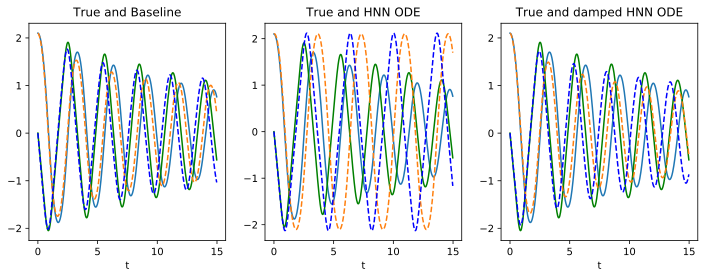

In [50]:

# plotting the difference between trajectories
tpad = 7
pts = 000
pte = 500
fig = plt.figure(figsize=[12, 4], dpi=DPI)
plt.subplot(1,3,1)
plt.title("True and Baseline", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], base_x[pts:pte,0], '--', t_eval[pts:pte], base_x[pts:pte,1], 'b--')

plt.subplot(1,3,2)
plt.title("True and HNN ODE", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], hnn_x[pts:pte,0], '--', t_eval[pts:pte], hnn_x[pts:pte,1], 'b--')

plt.subplot(1,3,3)
plt.title("True and damped HNN ODE", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], hnn_damp_x[pts:pte,0], '--', t_eval[pts:pte], hnn_damp_x[pts:pte,1], 'b--')


In [51]:
### noise, no bias, radius

In [64]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-damp/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn, arrange_data
from nn_models import MLP, PSD
from hnn import HNN, HNN_structure
from utils import L2_loss, from_pickle

# #%%
# pend_baseline_stats = from_pickle(EXPERIMENT_DIR + 'pend-baseline-stats.pkl')
# baseline_nfe = np.array(pend_baseline_stats['nfe'])
# baseline_diff_nfe = baseline_nfe[1:] - baseline_nfe[:-1]
# baseline_forward_time = np.array(pend_baseline_stats['forward_time'])
# baseline_backward_time = np.array(pend_baseline_stats['backward_time'])


# #%%
# pend_hnn_stats = from_pickle(EXPERIMENT_DIR + 'pend-hnn_ode-stats.pkl')
# hnn_nfe = np.array(pend_hnn_stats['nfe'])
# hnn_diff_nfe = hnn_nfe[1:] - hnn_nfe[:-1]
# hnn_forward_time = np.array(pend_hnn_stats['forward_time'])
# hnn_backward_time = np.array(pend_hnn_stats['backward_time'])


 ## Set some notebook constants

In [65]:
DPI = 300
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 4,
         'gpu': 0}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d


 ## Inspect the dataset

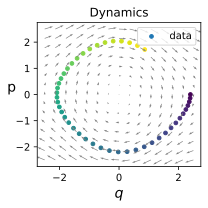

In [66]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
R = 2.5
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
# data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(radius=2.4, y0=np.array([2,0]), noise_std=0)
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')


In [67]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, damping, num_points):
    if structure == False:
        # Neural net without structure
        output_dim = args.input_dim if baseline else 1
        nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity).to(device)
        damp_model = PSD(input_dim=args.input_dim, hidden_dim=30, 
                    diag_dim=args.input_dim, nonlinearity=args.nonlinearity).to(device)
        model = HNN(args.input_dim, differentiale_model=nn_model, device=device, 
                baseline=baseline, damp=damping, dampNet=damp_model).to(device)
    elif structure and baseline == False:
        pass
    else:
        raise RuntimeError('argument *baseline* and *structure* cannot both be true')
    
    model_name = 'baseline_ode' if baseline else 'hnn_ode'
    struct = '-struct' if structure else ''
    damp = '-damp' if damping else ''
    path = '{}pend-{}{}{}-p{}.tar'.format(args.save_dir, model_name, struct, damp, num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    return model


 ## Get vector fields

In [68]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32).to(device)
    mesh_dx = model.time_derivative(_, mesh_x)
    return mesh_dx.detach().cpu().numpy()


 ## Integrate along vector fields

In [69]:
from torchdiffeq import odeint 
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2).to(device)
        dx = model.time_derivative(_, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)


 ## Run analysis

In [70]:
base_ode_model = get_model(args, baseline=True, structure=False, damping=False, num_points=args.num_points)
hnn_ode_model = get_model(args, baseline=False, structure=False, damping=False, num_points=args.num_points)
hnn_ode_damp_model = get_model(args, baseline=False, structure=False, damping=True, num_points=args.num_points)

# get their vector fields
R = 2.6
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
# data = get_dataset(radius=2.0)
base_field = get_vector_field(base_ode_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_ode_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
hnn_damp_field = get_vector_field(hnn_ode_damp_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,28]
# y0 = torch.tensor([[2.1, 0]], requires_grad=True).to(device)
y0 = np.asarray([2.1, 0])
# t_eval = torch.linspace(t_span[0], t_span[1], 1000).to(device)
# rtol = torch.tensor(1e-12, dtype=torch.float64)
# rtol = 1e-12
# base_ivp = odeint(base_ode_model.time_derivative, y0, t_eval, rtol=rtol) # (1000, 1, 2)
# hnn_ivp = odeint(hnn_ode_model.time_derivative, y0, t_eval, rtol=rtol)

kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_ode_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_ode_model, t_span, y0, **kwargs)
hnn_damp_ivp = integrate_model(hnn_ode_damp_model, t_span, y0, **kwargs)


In [71]:
# plot training data
data = get_dataset(args.seed)
train_x0 = data['x'][0,:,:] # (25, 2)


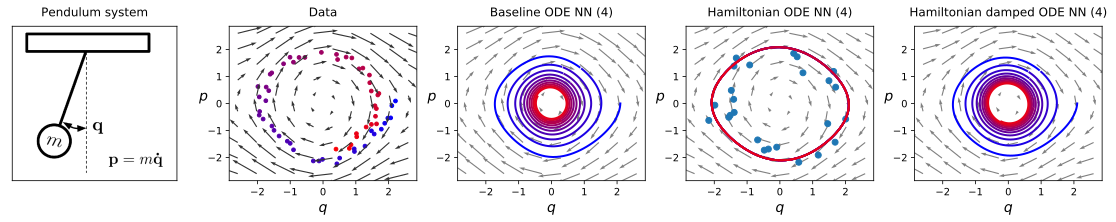

In [72]:
###### PLOT ######



fig = plt.figure(figsize=(16, 3.2), facecolor='white', dpi=DPI)
# plot physical system
fig.add_subplot(1, 5, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/pendulum.png')
plt.imshow(schema)
plt.title("Pendulum system", pad=10)

# plot dynamics
fig.add_subplot(1, 5, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=[0,4], radius=2.1, y0=y0)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=14, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 5, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline ODE NN ({})".format(args.num_points), pad=10)

# plot HNN
fig.add_subplot(1, 5, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian ODE NN ({})".format(args.num_points), pad=10)

plt.scatter(train_x0[:, 0], train_x0[:, 1])

# plot HNN damping
fig.add_subplot(1, 5, 5, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_damp_field[:,0], hnn_damp_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_damp_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian damped ODE NN ({})".format(args.num_points), pad=10)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend-damp-p{}.{}'.format(args.fig_dir, args.num_points, FORMAT))


 ## Quantitative analysis
 * Choose trajectories from the test set
 * Measure vector field loss at each point
 * Integrate along trajectory and measure mean loss between points

In [73]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # integrate along baseline vector field
    base_path = integrate_model(base_ode_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_ode_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_damp_path = integrate_model(hnn_ode_damp_model, t_span, x0, **kwargs)
    hnn_damp_x = hnn_damp_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    return true_x, base_x, hnn_x, hnn_damp_x

def vector_field_loss(x, dx_hat):
    dx = circular_vector_field(t=None, x=x)
    return np.mean((dx - dx_hat)**2)

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)


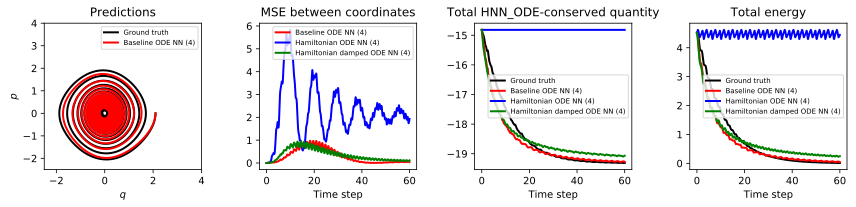

In [74]:
x0 = np.asarray([2.1, 0])

# integration
t_span=[0,60]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x, hnn_damp_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
# plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian ODE NN', linewidth=2)
# plt.plot(hnn_damp_x[:,0], hnn_damp_x[:,1], 'g-', label='Hamiltonian damped ODE NN', linewidth=2)
plt.xlim(-2.5,4) ; plt.ylim(-2.5,4)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, ((true_x-hnn_damp_x)**2).mean(-1), 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN_ODE-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_ode_model(torch.Tensor(true_x).to(device)).detach().cpu().numpy().squeeze()
base_hq = hnn_ode_model(torch.Tensor(base_x).to(device)).detach().cpu().numpy().squeeze()
hnn_hq = hnn_ode_model(torch.Tensor(hnn_x).to(device)).detach().cpu().numpy().squeeze()
hnn_damp_hq = hnn_ode_model(torch.Tensor(hnn_damp_x).to(device)).detach().cpu().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_damp_hq, 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
hnn_damp_e = np.stack([hamiltonian_fn(c) for c in hnn_damp_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian ODE NN ({})'.format(args.num_points), linewidth=2)
plt.plot(t_eval, hnn_damp_e, 'g-', label='Hamiltonian damped ODE NN ({})'.format(args.num_points), linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend-damp-p{}-integration.{}'.format(args.fig_dir, args.num_points, FORMAT))



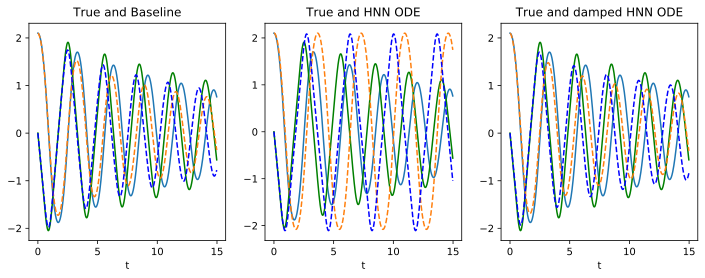

In [75]:

# plotting the difference between trajectories
tpad = 7
pts = 000
pte = 500
fig = plt.figure(figsize=[12, 4], dpi=DPI)
plt.subplot(1,3,1)
plt.title("True and Baseline", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], base_x[pts:pte,0], '--', t_eval[pts:pte], base_x[pts:pte,1], 'b--')

plt.subplot(1,3,2)
plt.title("True and HNN ODE", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], hnn_x[pts:pte,0], '--', t_eval[pts:pte], hnn_x[pts:pte,1], 'b--')

plt.subplot(1,3,3)
plt.title("True and damped HNN ODE", pad=tpad) ; plt.xlabel('t')
plt.plot(t_eval[pts:pte], true_x[pts:pte,0], t_eval[pts:pte], true_x[pts:pte,1], 'g-')
plt.plot(t_eval[pts:pte], hnn_damp_x[pts:pte,0], '--', t_eval[pts:pte], hnn_damp_x[pts:pte,1], 'b--')
